In [1]:
import os ,yaml
from operator import itemgetter
from tools.import_data import *
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs

In [3]:
def pre_processing(X_set,Y_set):
    # Data pre processing
    # Encoding Categorial features and imputing NaN's
    # https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    # http://pbpython.com/categorical-encoding.html
    # https://datascience.stackexchange.com/questions/14069/mass-convert-categorical-columns-in-pandas-not-one-hot-encoding
    char_cols = X_set.dtypes.pipe(lambda x: x[x == 'object']).index
    if not char_cols.empty:
        label_mapping = {}
        for c in char_cols:
            original_X_set = X_set.copy()
            X_set[c], label_mapping[c] = pd.factorize(X_set[c])
    imp = preprocessing.Imputer(axis=0, verbose=1)
    imp = imp.fit(X_set)
    X_set = imp.transform(X_set)
    
    lb = preprocessing.LabelBinarizer()
    Y_set = lb.fit_transform(Y_set).ravel()
    
    print ('Pre processing results: X_set-{} Y_set-{}'.format(X_set.shape,Y_set.shape))
    return X_set,Y_set

def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    #TODO add the option to more score method
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True)
        try:
            cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold,n_jobs=-1, scoring=SCORING )
        except ValueError as e:
            print('ValueError{}'.format(None))
        else:
            scores.append(cv_results)
            names.append(name)
            results.append({"name":name,"score":cv_results.mean()})


    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
        
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    results = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        results.append({"name":name,"score":accuracy_score(Y_test, predictions)})
    return results 

def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    name = results[i]["name"]
    printmd('The best model for the given data is: <span style="color:green">' + str(name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)

In [4]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = os.path.join(FILE_PATH,'config.yml')
config = yaml.load(open(CONFIG_FILE,'r'))
TRAIN_FILE = config['files']['train_set']
TEST_FILE = config['files']['test_set']
SCORING = config['score']

models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

if __name__ == "__main__":
    data_sets = []
    X_train, Y_train , original_headers_train = load_dataset(TRAIN_FILE) 
    data_sets.append({'X_train':X_train,'Y_train':Y_train,'original_headers_train':original_headers_train})
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    X_train, Y_train = pre_processing(X_train,Y_train)   
    if TEST_FILE:
        X_test, Y_test ,original_headers_test = load_dataset(TEST_FILE)
        data_sets.append({'X_test':X_test,'Y_test':Y_test,'original_headers_test':original_headers_test})
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)
        X_test, Y_test = pre_processing(X_test,Y_test)

Train data shape:  (398, 20)
Train labels shape:  (398,)
Pre processing results: X_set-(398, 20) Y_set-(398,)


In [5]:
    #create feature score list
    fs_scores = fs.mutual_info_classif(X_train,Y_train)
    feature_scores_list = []
    for i,score in enumerate(fs_scores):
        feature_scores_list.append({'feature_name':original_headers_train[i],'score':score})
    feature_scores_list.sort(key=itemgetter('score'),reverse=True)
    for feature in feature_scores_list:
        print (feature)

{'feature_name': 'WEIGHT', 'score': 0.14496748850578456}
{'feature_name': 'WAIST_CIRCUMFERENCE', 'score': 0.083530354611768498}
{'feature_name': 'SYM_TAKING_STOMACH_MEDS', 'score': 0.07653116488765388}
{'feature_name': 'SYM_BURNING_CHEST', 'score': 0.070437028816327185}
{'feature_name': 'SEX', 'score': 0.054667935024905523}
{'feature_name': 'SMK_EVER_SMOKED', 'score': 0.052447201177794334}
{'feature_name': 'AGE', 'score': 0.051799818108205109}
{'feature_name': 'SYM_SLEEP_DISRUPTED', 'score': 0.042768811812929464}
{'feature_name': 'SYM_SORE_THROAT', 'score': 0.041636149986318038}
{'feature_name': 'SYM_ACID_TASTE', 'score': 0.035401996896174515}
{'feature_name': 'PREFERRED_DRINK', 'score': 0.034697805080173394}
{'feature_name': 'SYM_CHEST_PAIN', 'score': 0.034693747067595426}
{'feature_name': 'SYM_YRS_SINCE_ACID_TASTE_START', 'score': 0.028739595279767771}
{'feature_name': 'SMK_AGE_STARTED', 'score': 0.024641628335776211}
{'feature_name': 'ALC_UNITS_PER_WEEK', 'score': 0.0216237037208959

In [7]:
    #carate new 
    new_trains = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        X_train_mod = sel.fit_transform(X_train,Y_train)
        if len(new_trains) >= 1:
            if new_trains[-1]['ratio']!= X_train_mod.shape[-1]/X_train.shape[-1]:
                # new_range.append(VTHRESH)
                # new_trains.append(X_train_mod)
                # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
                mask = sel.get_support() #list of booleans
                new_features = [] # The list of your K best features    
                for bool, feature in zip(mask, original_headers_train):
                    if bool:
                        new_features.append(feature)
                new_trains.append({'threshold':VTHRESH,
                                   'X_train':X_train_mod,
                                   'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                                   'features_name':new_features,
                                   'traind_model':None
                                   })
                
        else:
            # new_range.append(VTHRESH)
            # new_trains.append(X_train_mod)
            # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
            mask = sel.get_support() #list of booleans
            new_features = [] # The list of your K best features    
            for bool, feature in zip(mask, original_headers_train):
                if bool:
                    new_features.append(feature)
            new_trains.append({'threshold':VTHRESH,
                               'X_train':X_train_mod,
                               'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                               'features_name':new_features,
                               'traind_model':None})

**Training Section** for: 1 features (['WEIGHT'])

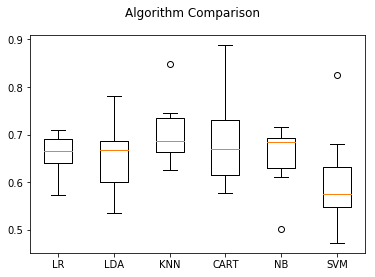

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.701565789474</span>

{'name': 'LR', 'score': 0.65540131578947369}
{'name': 'LDA', 'score': 0.65746710526315799}
{'name': 'KNN', 'score': 0.7015657894736842}
{'name': 'CART', 'score': 0.68923026315789482}
{'name': 'NB', 'score': 0.65836842105263149}
{'name': 'SVM', 'score': 0.60132894736842102}


**Training Section** for: 2 features (['AGE', 'WEIGHT'])

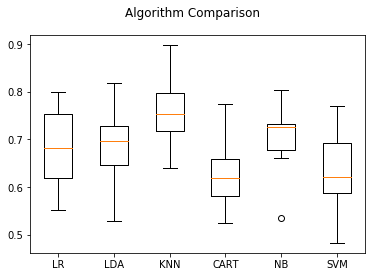

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.756506578947</span>

{'name': 'LR', 'score': 0.68469078947368422}
{'name': 'LDA', 'score': 0.68930263157894733}
{'name': 'KNN', 'score': 0.7565065789473685}
{'name': 'CART', 'score': 0.63240131578947367}
{'name': 'NB', 'score': 0.70250000000000001}
{'name': 'SVM', 'score': 0.62922368421052632}


**Training Section** for: 3 features (['WEIGHT', 'SYM_CHEST_PAIN', 'SYM_YRS_SINCE_ACID_TASTE_START'])

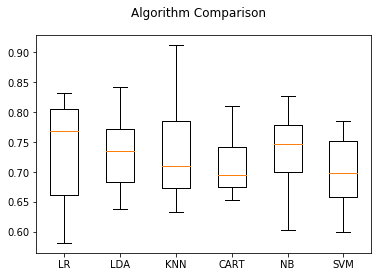

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.736671052632</span>

{'name': 'LR', 'score': 0.73482894736842108}
{'name': 'LDA', 'score': 0.73667105263157895}
{'name': 'KNN', 'score': 0.73588815789473683}
{'name': 'CART', 'score': 0.70884868421052638}
{'name': 'NB', 'score': 0.73459868421052632}
{'name': 'SVM', 'score': 0.69874342105263154}


**Training Section** for: 4 features (['WEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_TAKING_STOMACH_MEDS'])

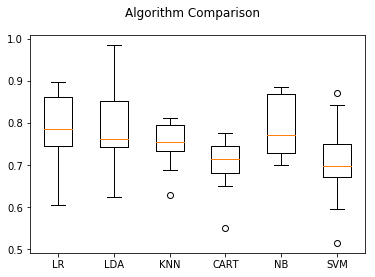

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.790052631579</span>

{'name': 'LR', 'score': 0.78992763157894752}
{'name': 'LDA', 'score': 0.78931578947368419}
{'name': 'KNN', 'score': 0.74826315789473685}
{'name': 'CART', 'score': 0.70426973684210525}
{'name': 'NB', 'score': 0.79005263157894734}
{'name': 'SVM', 'score': 0.70592105263157889}


**Training Section** for: 5 features (['WEIGHT', 'ALC_UNITS_PER_WEEK', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_TAKING_STOMACH_MEDS'])

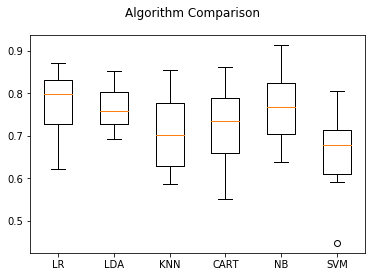

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.768289473684</span>

{'name': 'LR', 'score': 0.76813157894736839}
{'name': 'LDA', 'score': 0.76434868421052637}
{'name': 'KNN', 'score': 0.70572368421052623}
{'name': 'CART', 'score': 0.72119078947368431}
{'name': 'NB', 'score': 0.76828947368421052}
{'name': 'SVM', 'score': 0.66359210526315793}


**Training Section** for: 6 features (['HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_TAKING_STOMACH_MEDS'])

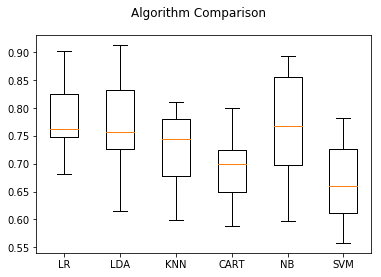

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.784960526316</span>

{'name': 'LR', 'score': 0.7849605263157895}
{'name': 'LDA', 'score': 0.77263157894736834}
{'name': 'KNN', 'score': 0.7244605263157895}
{'name': 'CART', 'score': 0.68828947368421056}
{'name': 'NB', 'score': 0.76831578947368417}
{'name': 'SVM', 'score': 0.66819078947368427}


**Training Section** for: 7 features (['AGE', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_TAKING_STOMACH_MEDS'])

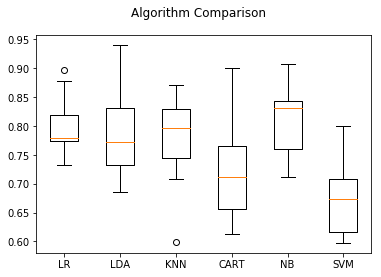

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.814092105263</span>

{'name': 'LR', 'score': 0.7978421052631578}
{'name': 'LDA', 'score': 0.7847763157894736}
{'name': 'KNN', 'score': 0.77634868421052627}
{'name': 'CART', 'score': 0.72328947368421059}
{'name': 'NB', 'score': 0.81409210526315801}
{'name': 'SVM', 'score': 0.67284868421052635}


**Training Section** for: 8 features (['AGE', 'SEX', 'WEIGHT', 'SMK_AGE_STARTED', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

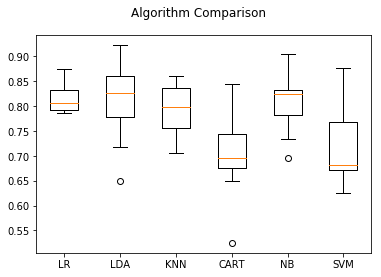

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.81525</span>

{'name': 'LR', 'score': 0.81525000000000003}
{'name': 'LDA', 'score': 0.81101315789473671}
{'name': 'KNN', 'score': 0.79386184210526312}
{'name': 'CART', 'score': 0.70355263157894732}
{'name': 'NB', 'score': 0.81301315789473672}
{'name': 'SVM', 'score': 0.72419736842105265}


**Training Section** for: 9 features (['AGE', 'SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SYM_CHEST_PAIN', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_TAKING_STOMACH_MEDS'])

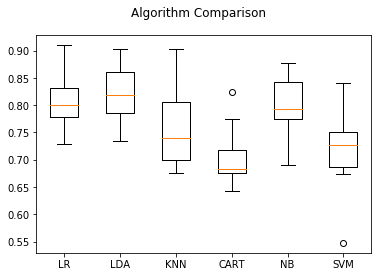

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.817960526316</span>

{'name': 'LR', 'score': 0.80981578947368438}
{'name': 'LDA', 'score': 0.81796052631578942}
{'name': 'KNN', 'score': 0.76107236842105253}
{'name': 'CART', 'score': 0.70355263157894732}
{'name': 'NB', 'score': 0.8012631578947369}
{'name': 'SVM', 'score': 0.71873026315789479}


**Training Section** for: 10 features (['AGE', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

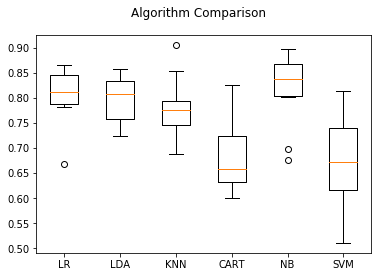

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.816171052632</span>

{'name': 'LR', 'score': 0.80640789473684227}
{'name': 'LDA', 'score': 0.79847368421052622}
{'name': 'KNN', 'score': 0.78148026315789476}
{'name': 'CART', 'score': 0.68618421052631573}
{'name': 'NB', 'score': 0.81617105263157885}
{'name': 'SVM', 'score': 0.67277631578947372}


**Training Section** for: 11 features (['SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

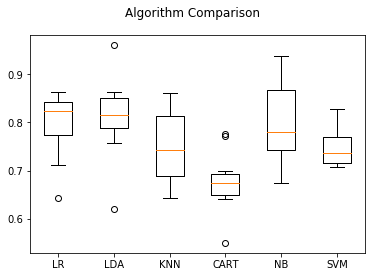

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.809921052632</span>

{'name': 'LR', 'score': 0.79542105263157892}
{'name': 'LDA', 'score': 0.80992105263157899}
{'name': 'KNN', 'score': 0.74988157894736851}
{'name': 'CART', 'score': 0.6763157894736842}
{'name': 'NB', 'score': 0.80252631578947375}
{'name': 'SVM', 'score': 0.75001315789473688}


**Training Section** for: 12 features (['AGE', 'SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_TAKING_STOMACH_MEDS'])

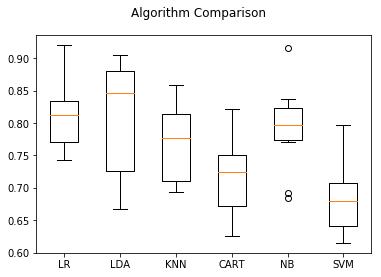

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.813776315789</span>

{'name': 'LR', 'score': 0.81377631578947374}
{'name': 'LDA', 'score': 0.80843421052631581}
{'name': 'KNN', 'score': 0.76991447368421051}
{'name': 'CART', 'score': 0.72105263157894739}
{'name': 'NB', 'score': 0.79180263157894726}
{'name': 'SVM', 'score': 0.69021710526315794}


**Training Section** for: 13 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'ALC_UNITS_PER_WEEK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

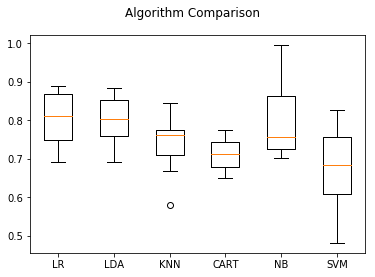

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.805065789474</span>

{'name': 'LR', 'score': 0.80506578947368401}
{'name': 'LDA', 'score': 0.8019078947368421}
{'name': 'KNN', 'score': 0.74198684210526322}
{'name': 'CART', 'score': 0.7114473684210525}
{'name': 'NB', 'score': 0.80309210526315788}
{'name': 'SVM', 'score': 0.6686381578947368}


**Training Section** for: 14 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

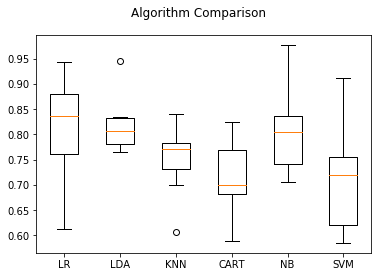

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.815302631579</span>

{'name': 'LR', 'score': 0.81414473684210509}
{'name': 'LDA', 'score': 0.81530263157894733}
{'name': 'KNN', 'score': 0.75675000000000003}
{'name': 'CART', 'score': 0.71092105263157879}
{'name': 'NB', 'score': 0.80490789473684221}
{'name': 'SVM', 'score': 0.70810526315789468}


**Training Section** for: 15 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_STARTED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

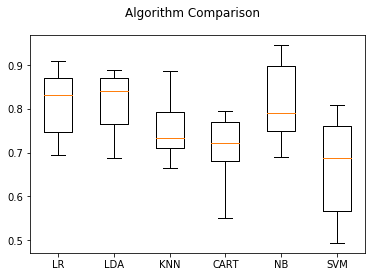

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.816828947368</span>

{'name': 'LR', 'score': 0.8093157894736841}
{'name': 'LDA', 'score': 0.81682894736842115}
{'name': 'KNN', 'score': 0.75638815789473679}
{'name': 'CART', 'score': 0.71381578947368429}
{'name': 'NB', 'score': 0.81563157894736837}
{'name': 'SVM', 'score': 0.66371710526315797}


**Training Section** for: 16 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_STARTED', 'ALC_UNITS_PER_WEEK', 'ALC_DRINK_HEAVILY', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

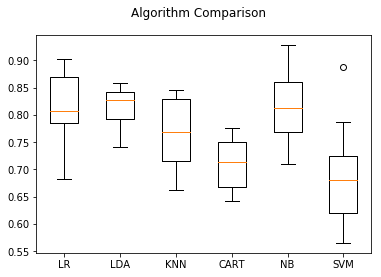

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.817039473684</span>

{'name': 'LR', 'score': 0.80998684210526317}
{'name': 'LDA', 'score': 0.81272368421052621}
{'name': 'KNN', 'score': 0.76375000000000004}
{'name': 'CART', 'score': 0.71065789473684204}
{'name': 'NB', 'score': 0.81703947368421059}
{'name': 'SVM', 'score': 0.68580263157894739}


**Training Section** for: 17 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

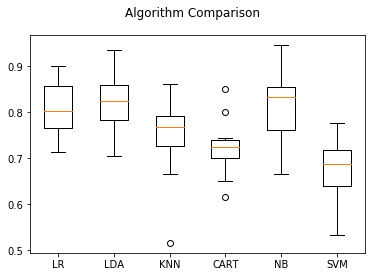

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.820789473684</span>

{'name': 'LR', 'score': 0.80390789473684199}
{'name': 'LDA', 'score': 0.82078947368421051}
{'name': 'KNN', 'score': 0.74525657894736841}
{'name': 'CART', 'score': 0.72342105263157896}
{'name': 'NB', 'score': 0.81282894736842104}
{'name': 'SVM', 'score': 0.67101973684210514}


**Training Section** for: 18 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

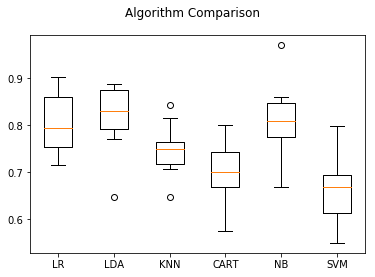

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.818197368421</span>

{'name': 'LR', 'score': 0.80759210526315783}
{'name': 'LDA', 'score': 0.81819736842105262}
{'name': 'KNN', 'score': 0.74890131578947361}
{'name': 'CART', 'score': 0.70394736842105265}
{'name': 'NB', 'score': 0.80757894736842106}
{'name': 'SVM', 'score': 0.66033552631578951}


**Training Section** for: 19 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

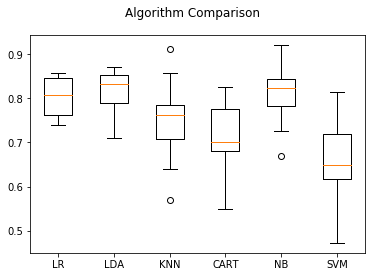

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.814657894737</span>

{'name': 'LR', 'score': 0.80261842105263148}
{'name': 'LDA', 'score': 0.81465789473684214}
{'name': 'KNN', 'score': 0.748203947368421}
{'name': 'CART', 'score': 0.70868421052631569}
{'name': 'NB', 'score': 0.80927631578947368}
{'name': 'SVM', 'score': 0.64785526315789477}


In [8]:
    best_tr_results = []
    # new_trains.rever()
    new_models = []
    for train_set in new_trains:
        X_train_mod = train_set['X_train']
        printmd("**Training Section** for: {} features ({})".format(str(X_train_mod.shape[-1]),train_set['features_name']))
        train_resultes = train_the_data(X_train_mod,Y_train,models)
        new_models.append({'train_set':train_set,'train_resultes':train_resultes})
        if train_resultes:
            best_tr = get_the_best(train_resultes)
            best_tr_results.append({"name":best_tr['name'],
                                    "score":best_tr['score'],
                                    "num_fetures":int(X_train_mod.shape[-1]),
                                    'features_names':train_set['features_name']})
            for model in train_resultes:
                print (model)

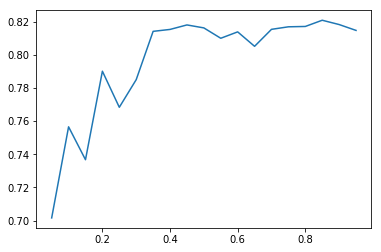

{'name': 'LDA', 'score': 0.82078947368421051, 'num_fetures': 17, 'features_names': ['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LDA', 'score': 0.81819736842105262, 'num_fetures': 18, 'features_names': ['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LDA', 'score': 0.81796052631578942, 'num_fetures': 9, 'features_names': ['AGE', 'SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LE

In [9]:
    plt.plot([d['ratio'] for d in new_trains],
             [d['score'] for d in best_tr_results])
    plt.legend()
    plt.show()
    best_tr_results.sort(key=itemgetter('score'),reverse=True)
    for best in best_tr_results:
        print(best)

In [9]:
#need to modify the test shape
    printmd("**Testing Section:**")
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,models)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


IndentationError: unexpected indent (<ipython-input-9-55d60a75eb15>, line 2)

In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)